# Maximum Likelihood Estimation (MLE)
## Fitting your models

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats

### $y$ is *distributed according* to a function:

- $p(y) = f(\mu,\sigma,...)$, where f is a probability distribution
- Also sometimes written as y ~ $f(\mu,\sigma,...)$  

### $\mu$ (and $\sigma$, etc.) are *equal* to function like:
- $\mu = g(x)$

### Altogether, this is our *statistical model* of the data

In [2]:
# Functions mu = g(x)

def linear(x, m=3, b=1):
    return m*x + b

def inverse(x, m=3, b=0.25):
    return 1/(m*x+b)

def logarithm(x, m=0.25, b=4.5):
    return b + np.log(m*x+0.01)

def sigmoidal(x, m=10, b=0.5):
    return 4/(1+np.exp(-m*(x-b)))

In [3]:
# Distributions y ~ p(mu)

def normal(x,var=0.5):
    return scipy.stats.norm.rvs(loc=x,scale=np.ones(x.shape)*var)

def exponential(x):
    return scipy.stats.expon.rvs(scale=x)

def poisson(x):
    return scipy.stats.poisson.rvs(x)

def binomial(x,n=4):
    return scipy.stats.binom.rvs(n,x/n)

In [4]:
def plots(all=True):
    x = np.linspace(0.01,1,100)
    fig,axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(15,10))
    for i,func in enumerate([linear,inverse,logarithm,sigmoidal]):
        for j,distribution in enumerate([normal,exponential,poisson,binomial]):
            y_mean = func(x)
            y = distribution(y_mean)
            if i==j or all:
                axes[i,j].plot(x,y_mean,'rgbm'[j],linewidth=5)
                axes[i,j].scatter(x,y,color='k')
            if i!=j and not all:
                axes[i,j].axis('off')
            if i==j and not all:
                axes[i,j].set_ylabel(func.__name__)
                axes[i,j].set_xlabel(distribution.__name__)
            axes[i,0].set_ylabel(func.__name__)
            axes[3,j].set_xlabel(distribution.__name__)

## Linear regression on normally distributed data is a special case of maximum likelihood estimation

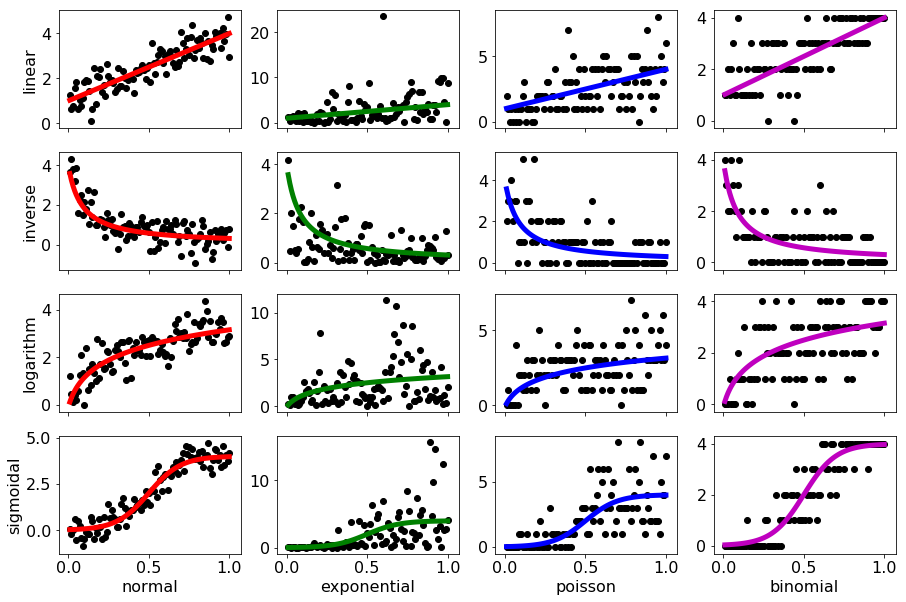

In [5]:
mpl.rcParams.update({'font.size':16})
plots()

## Linear regression, Normally distributed data

$p(y_i|\mu_i,\sigma_i) = \frac{e^{-(y_i-\mu_i)^2/\sigma_i^2}}{2\pi\sigma_i}$

$\mu_i = mx_i + b$

$p(y_i|\mu_i,\sigma_i) = \frac{e^{-(y_i-\mu_i)^2/\sigma_i^2}}{2\pi\sigma_i}$

$log(p(y_i|\mu_i,\sigma_i)) = log(\frac{e^{-(y_i-\mu_i)^2/\sigma_i^2}}{2\pi\sigma_i})$

$ = log(e^{-(y_i-\mu_i)^2/\sigma_i^2}) - log(2\pi\sigma_i)$

$ = \frac{-(y_i-\mu_i)^2}{\sigma_i^2} - log(2\pi\sigma_i)$

## $log(p(y_i|\mu_i,\sigma_i)) = \frac{-(y_i-\mu_i)^2}{\sigma_i^2} - log(2\pi\sigma_i)$

## Maximizing the log likelihood means minimizing $(y_i-\mu_i)^2$

### When the $y_i$'s are normally distributed around the $\mu_i$'s, and all the $\sigma_i$'s are the same, the best fit is the one that minimizes the sum of the squared errors

In [6]:
x = np.linspace(0,10,100)
a = 15 # The maximum mean firing rate
b = 0.5 # How fast the firing rate decays over space

def g(x,a,b):
    return a*np.exp(-b*x)

mu = g(x,a,b)
y = poisson(mu)

def plot(x,y,a,b,est=False):
    mu = g(x,a,b)
    plt.plot(x,mu,linewidth=3,label='$\mu%s=a*e^{-b*x}$' % ('_{est}' if est else ''))
    plt.scatter(x,y,color='k',label='data');
    plt.xlabel("Distance on track (m)")
    plt.ylabel("Neuron's spike count")
    plt.ylim(-1,y.max()*1.5)
    plt.legend();

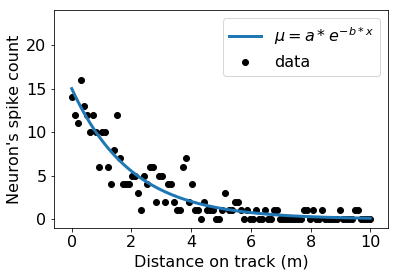

In [7]:
plot(x,y,a,b)

# Our statistical model

## $\mu_i=g(x_i,a,b)=a*e^{-bx_i}$

## $p(y_i|\mu_i) = f(y_i,\mu_i) = \frac{\mu_i^{y_i}e^{-\mu_i}}{y_i!}$

# Fitting this model the hard way...

In [8]:
from scipy.optimize import minimize

In [9]:
def g(x,a,b):
    return a*np.exp(-b*x)

def f(y,mu):
    return scipy.stats.poisson.pmf(y,mu)

In [10]:
def log_likelihood(x,y,a,b):
    mu = g(x,a,b)
    likelihoods = f(y,mu)
    log_likelihoods = np.log(likelihoods)
    return sum(log_likelihoods)

In [11]:
def function_to_minimize(params,x,y):
    a,b = params
    log_l = log_likelihood(x,y,a,b)
    return -log_l # We want to maximize log_l so we return its negative

In [12]:
result = minimize(function_to_minimize,[1,1],
                  args=(x,y),bounds=[(1e-9,None)]*2)
a_est,b_est = result.x

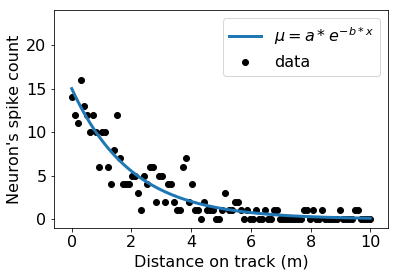

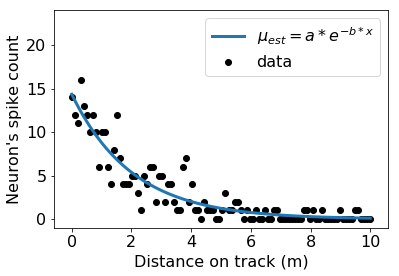

In [13]:
plot(x,y,a,b)
plt.figure()
plot(x,y,a_est,b_est,est=True)
plt.legend();

# Generalized linear models

## $G(\mu_i) = k_0 + k_1f_1(x_i) + k_2f_2(x_i) + k_3f_3(x_i) + ...$

## $G$ is called the link function
### $G$ can be identity, log, logit, inverse, etc.  

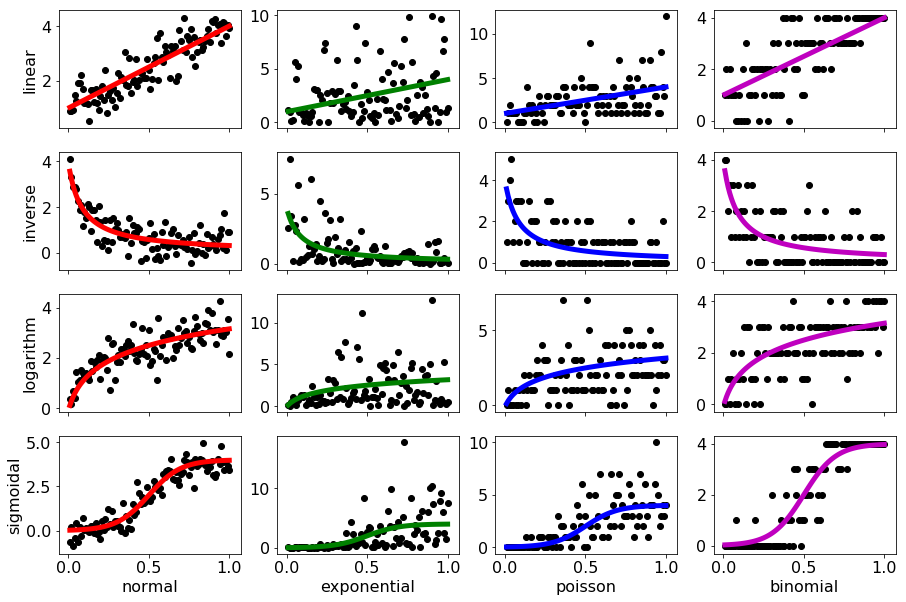

In [14]:
plots()

## $\mu_i=a*e^{-bx_i}$

## $log(\mu_i) = log(a) - bx_i$

## $G(\mu_i) = k_0 + k_1f_1(x_i)$

# Fitting our model the easy way...

In [15]:
import statsmodels.api as sm
x_new = sm.add_constant(x)
model = sm.GLM(y, x_new, family=sm.families.Poisson(link=sm.families.links.log))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -141.10
Date:                Mon, 19 Feb 2018   Deviance:                       84.808
Time:                        06:06:53   Pearson chi2:                     87.8
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6640      0.084     31.781      0.000       2.500       2.828
x1            -0.4902      0.031    -15.591      0.0

## $log(\mu_i) = 2.63 + 0.46x_i$

## $\mu_i = e^{2.63 + 0.46*x_i} = 13.87*e^{0.46x_i} \sim 15*e^{0.5x_i}$

## DON'T just do linear regression!

## DON'T just transform your data and do linear regression!

## DO use generalized linear models to correctly accounts for the structure of your uncertainty

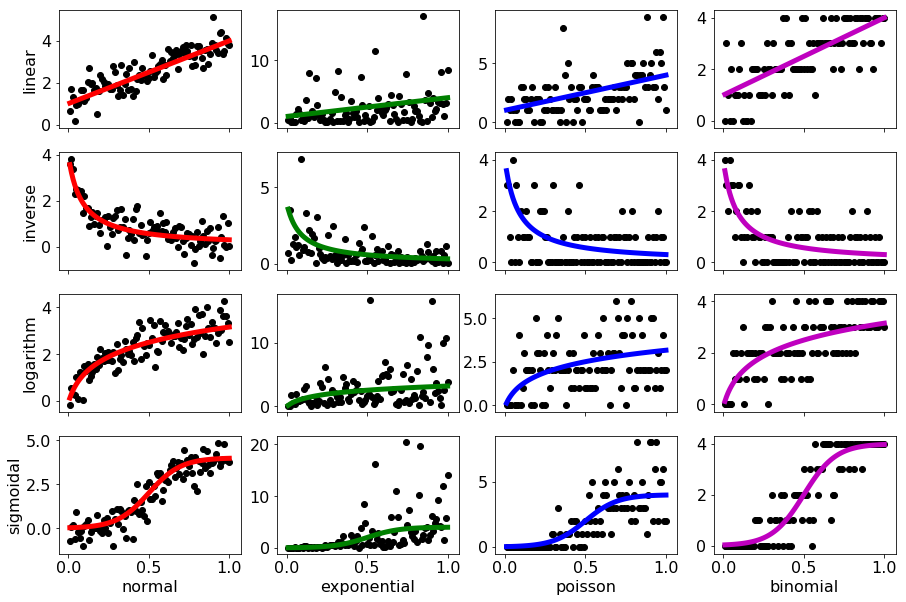

In [17]:
plots()